# Bagging

**Bagging**, or **Bootstrap Aggregating**, is a type of ensemble method that improves the stability and accuracy of machine learning algorithms by training multiple models on different subsets randomly sampled (with replacement) from the training data and then aggregating their predictions.

The main steps involved in bagging are:

1.  **Bootstrap Sampling**: Create multiple bootstrap samples from the original training dataset. Each bootstrap sample is created by randomly selecting instances from the original dataset with replacement, meaning some instances may appear multiple times while others may not appear at all.
2.  **Model Training**: Train a separate model on each bootstrap sample. This can be any machine learning algorithm, but decision trees are commonly used due to their high variance and low bias.
3.  **Aggregation**: For regression tasks, the predictions from all models are averaged to produce the final prediction. For classification tasks, a majority vote is taken among the predictions of all models to determine the final class label.
4.  **Final Prediction**: The aggregated prediction is then used as the final output of the bagging ensemble.

## Advantages and Disadvantages

Bagging has several advantages and disadvantages that make it suitable for various machine learning tasks:

-   **Advantages**:
    -   Can reduce variance and help prevent overfitting by averaging predictions from multiple models.
    -   Can improve accuracy, especially with high-variance models like decision trees.
    -   Robust to noise and outliers, as the aggregation process smooths out individual model errors.
    -   Can be parallelized, as each model can be trained independently on its bootstrap sample, making it efficient for large datasets.
-   **Disadvantages**:
    -   Requires more computational resources due to training multiple models.
    -   May not significantly improve performance if the base model is already stable and has low variance.

### Example

We will illustrate the concept of bagging using a simple example with a synthetic dataset. We will compare the performance of a single `DecisionTreeClassifier` model with a Bagging Classifier that uses the same model as its base estimator.

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2,
                           n_redundant=0, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=42)

# Train a single DecisionTreeClassifier model
single_model = DecisionTreeClassifier(random_state=42)
single_model.fit(X_train, y_train)

# Evaluate the single model
single_accuracy = single_model.score(X_test, y_test)
print(f"Single DecisionTreeClassifier Accuracy: {single_accuracy:.2f}")

# Train a Bagging model with DecisionTreeClassifier as estimator
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(),
                                  n_estimators=100, random_state=42)
bagging_model.fit(X_train, y_train)

# Evaluate the model
accuracy = bagging_model.score(X_test, y_test)
print(f"Bagging Classifier Accuracy: {accuracy:.2f}")

Single DecisionTreeClassifier Accuracy: 0.90
Bagging Classifier Accuracy: 0.92


The Bagging Classifier typically achieves higher accuracy than the single Decision Tree model due to the reduction in variance and improved generalization.

## Random Forests

**Random Forests** is a popular ensemble method that uses bagging with decision trees as base models. It introduces additional randomness by selecting a random subset of features for each split in the decision tree, which helps to decorrelate the trees and further reduce overfitting.

This method combines the strengths of bagging and decision trees, resulting in a powerful and flexible model that can handle both classification and regression tasks effectively.

### Example: Random Forest Classifier on the Titanic Dataset

To illustrate the use of Random Forest, we will use the Titanic dataset and apply a Random Forest classifier. We will compare its performance with a single decision tree classifier to highlight the benefits of bagging.

-   Load the Titanic dataset

In [2]:
import pandas as pd
from sklearn.datasets import fetch_openml

data = fetch_openml('titanic', version=1, as_frame=True)
df = data.frame

df_sub = df[['pclass', 'sex', 'age', 'survived']].copy()

X = df_sub.drop('survived', axis=1)
y = df_sub['survived']

-   Split the dataset into training and testing sets

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")
print(f"Features: {X_train.columns.tolist()}")

Training set size: 916, Test set size: 393
Features: ['pclass', 'sex', 'age']


-   Preprocess the data

In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Create a preprocessing pipeline
preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('num', Pipeline(
            steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]
        ), ['age']),
        ('sex', Pipeline(steps=[
            ('encoder', OneHotEncoder(drop='first', sparse_output=False))
        ]), ['sex']),
        ('pclass', Pipeline(steps=[
            ('encoder', OneHotEncoder(sparse_output=False))
        ]), ['pclass'])
    ],
    remainder='passthrough'
)

# Fit and transform the training data
X_train_transformed = preprocessing_pipeline.fit_transform(X_train)
X_test_transformed = preprocessing_pipeline.transform(X_test)

-   Train a single Decision Tree classifier

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Single Decision Tree Classifier Accuracy: 0.76
Feature Importances from Single Decision Tree:
sex__sex_male       0.580959
pclass__pclass_3    0.226990
num__age            0.147395
pclass__pclass_1    0.042398
pclass__pclass_2    0.002258
dtype: float64


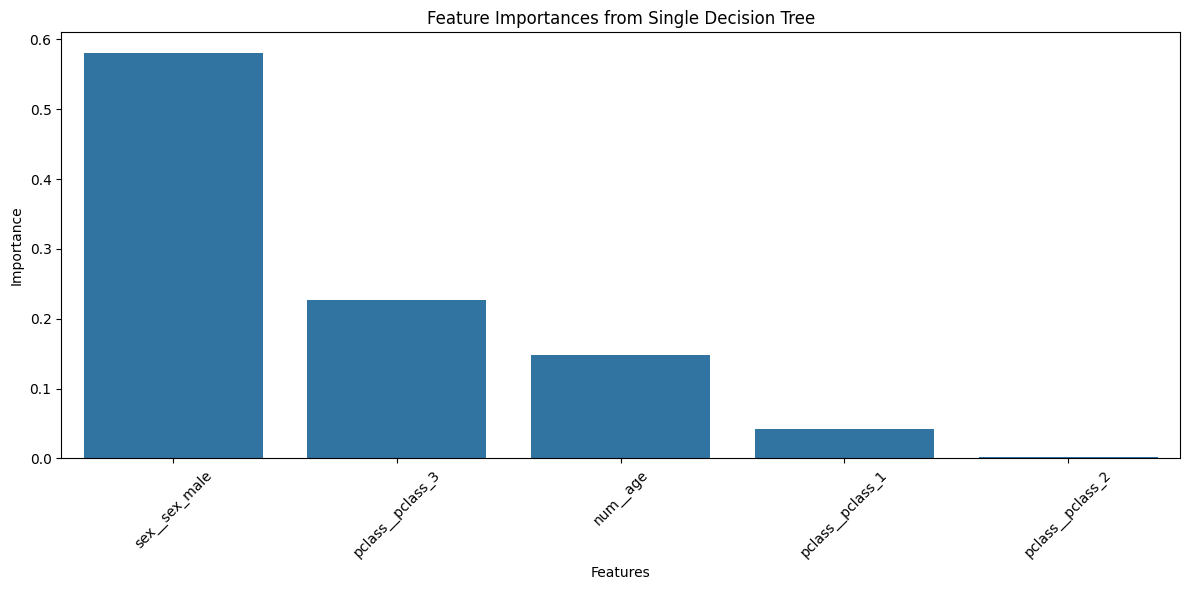

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Train a single Decision Tree classifier
single_tree_model = DecisionTreeClassifier(random_state=42)
grid_params = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(single_tree_model, grid_params, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_transformed, y_train)
single_tree_model = grid_search.best_estimator_
single_tree_model.fit(X_train_transformed, y_train)

# Evaluate the single model
single_tree_accuracy = single_tree_model.score(X_test_transformed, y_test)
print(f"Single Decision Tree Classifier Accuracy: {single_tree_accuracy:.2f}")

# Feature importances
single_tree_importances = single_tree_model.feature_importances_
st_indices = single_tree_importances.argsort()[::-1]

feature_names = preprocessing_pipeline.get_feature_names_out()
feature_importances = pd.Series(single_tree_importances, index=feature_names)
print("Feature Importances from Single Decision Tree:")
print(feature_importances.sort_values(ascending=False))

# Plot feature importances
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances.sort_values(ascending=False).index,
            y=feature_importances.sort_values(ascending=False).values)
plt.title('Feature Importances from Single Decision Tree')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

-   Train a Random Forest classifier

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Random Forest Classifier Accuracy: 0.77
Feature Importances from Random Forest:
sex__sex_male       0.528668
num__age            0.232155
pclass__pclass_3    0.112150
pclass__pclass_1    0.102198
pclass__pclass_2    0.024828
dtype: float64


<Axes: xlabel='Feature'>

<Figure size 1200x600 with 0 Axes>

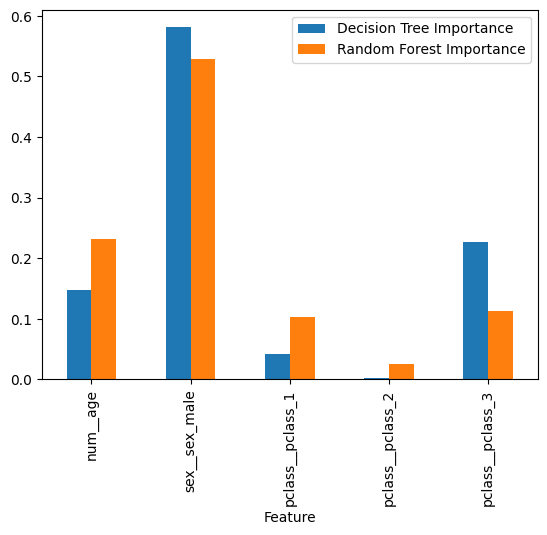

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
grid_params_rf = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2']
}

# Perform grid search for hyperparameter tuning
grid_search_rf = GridSearchCV(rf_model, grid_params_rf, cv=5, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train_transformed, y_train)
rf_model = grid_search_rf.best_estimator_
rf_model.fit(X_train_transformed, y_train)

# Evaluate the Random Forest model
rf_accuracy = rf_model.score(X_test_transformed, y_test)
print(f"Random Forest Classifier Accuracy: {rf_accuracy:.2f}")

# Feature importances
rf_importances = rf_model.feature_importances_
rf_feature_importances = pd.Series(rf_importances, index=feature_names)
print("Feature Importances from Random Forest:")
print(rf_feature_importances.sort_values(ascending=False))

# Create a dataframe for feature importances
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Decision Tree Importance': single_tree_importances,
    'Random Forest Importance': rf_importances
}).set_index('Feature')

# Compare feature importances
import matplotlib.pyplot as plt
import seaborn as sns

# Plot feature importances from Random Forest and Single Decision Tree in a stacked bar chart
plt.figure(figsize=(12, 6))
feature_importances.plot(kind='bar', stacked=False)

## Hands-on Exercises

**Bagging with Different Base Models**: Implement bagging using different base models (e.g., logistic regression, SVM) and compare their performance on a classification dataset.

-   Load the dataset
-   Train a Bagging Classifier with Logistic Regression as the base model
-   Train a Bagging Classifier with SVM as the base model